# Predicting the Number of Bikes Rented in Seoul within an Hour

Catherine Al Aswad

Student ID: 305541

CS4120: Machine Learning, Data Mining, Assignment 1

Date: 25 February 2021

In [1]:
import random
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
random.seed(6)

## Introduction:

### The Motivation:

The aim of this report is to predict a continous label. That aim was chosen since I already have experience with conducting polynomial regression but never knew how to choose an appropriate polynomial degree. So, the underling purpose of this study is for me to apply machine learning to choose an appropriate polynomial degree and obtain an adequate prediction model. 

This project uses the 'Seoul Bike Sharing Demand Data Set' from the UCI repository [1](UCI,https://archive.ics.uci.edu/ml/datasets/Seoul+Bike+Sharing+Demand). The dataset contains information about the count of public bikes rented and weather conditions at each hour in Seoul's Bike Sharing System from 2017 and 2018. The Seoul Bike Sharing System was started by the Seoul Metropolitan Government (SMG) to reduce traffic and pollution in the city [2](Bo-eun,Kim.'Seoul's_bike-sharing_system_gaining_popularity',The_Korea_Times.(2016-09-19).Accessed:Feb_2021.https://www.koreatimes.co.kr/www/nation/2021/01/113_214248.html). With the increase in popularity of the Sytem amoung the residence in Seoul, predicting the number of bikes rented under certain conditions can help the SMG improve the services of the Seoul Bike Sharing System.


### The Objective and Approach:

The objective of this study is to predict the number of public bikes rented within an hour, on days where the biking sharing system is open and operating, using some of the following features:
* Hour: Hour of the day.
* Temperature(°C)
* Humidity(%)
* Wind speed (m/s)
* Dew point temperature(°C)
* Seasons: Winter, Spring, Summer, Autum
* Holiday: Holiday/No holiday
* Visibility (10m)
* Solar Radiation (MJ/m2)
* Rainfall(mm)
* Snowfall (cm)

The 'Date' variable from the dataset will not be considered, since the focus is on the hour rather than the specific year-month-day date. Also, there is a 'Functional Day' feature in the dataset that will be held constant at 'Fun(Functional hours)', since we know that no bikes are rented when there are no functional hours. 

There is no missing data in the dataset and by considering only functional days, we are using 8465 observations of the original 8760 observations (96.6% of the original dataset).



In [2]:
# reading the dataset and only the columns we want:
SeoulBikeData = pd.read_csv('SeoulBikeData.csv', encoding= 'unicode_escape')
SeoulBikeDataTidy = SeoulBikeData[['Rented Bike Count', 'Hour', 'Temperature(°C)', 
                                   'Humidity(%)', 'Wind speed (m/s)', 'Dew point temperature(°C)', 
                                   'Seasons', 'Holiday', 'Functioning Day', 
                                   'Visibility (10m)', 'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)']]


# To show that there is no bike renting on non-functional days:
# SeoulBikeDataTidy.pivot_table('Rented Bike Count',
#                              index = 'Functioning Day',
#                              aggfunc = 'sum')

# keeping on the data on functional days:
SeoulBikeDataTidy = SeoulBikeDataTidy.loc[SeoulBikeDataTidy['Functioning Day']=='Yes']

In [3]:
# checking for missing values:
SeoulBikeDataTidy = SeoulBikeDataTidy.replace(r'^\s*$', np.nan, regex=True)
## SeoulBikeDataTidy.isna().sum()

From the table below, we see that the label of interest 'Rented Bike Count', although discrete, has a wide range of values and large standard deviation. Also, this label has no identified upper limit, since future data can have the Rented Bike Count go beyond 3556 bikes. Hence, there is no set number of categories or values for the label in question. To predict the Rented Bike Count label, the polynimial regression approach will be used. Additionally, the continous features in the dataset all have distinct ranges of different widths, and that will have to be handled later in the report.  

Notice in the table below that min = 25% = 50% = 75% = 0 for the Rainfall and Snowfall features, with each having large maximums. This indicates that the features have a heavily right skewed distribution.

In [4]:
# getting a summary of the data:
SeoulBikeDataTidy.describe(include= 'all')

,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Dew point temperature(°C),Seasons,Holiday,Functioning Day,Visibility (10m),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm)
count,8465.000000,8465.000000,8465.000000,8465.000000,8465.000000,8465.000000,8465,8465,8465,8465.000000,8465.000000,8465.00000,8465.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,4,2,1,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,Summer,No Holiday,Yes,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,2208,8057,8465,NaN,NaN,NaN,NaN
mean,729.156999,11.507029,12.771057,58.147194,1.725883,3.944997,NaN,NaN,NaN,1433.873479,0.567868,0.14912,0.077685
std,642.351166,6.920899,12.104375,20.484839,1.034281,13.242399,NaN,NaN,NaN,609.051229,0.868245,1.12554,0.444063
min,2.000000,0.000000,-17.800000,0.000000,0.000000,-30.600000,NaN,NaN,NaN,27.000000,0.000000,0.00000,0.000000
25%,214.000000,6.000000,3.000000,42.000000,0.900000,-5.100000,NaN,NaN,NaN,935.000000,0.000000,0.00000,0.000000
50%,542.000000,12.000000,13.500000,57.000000,1.500000,4.700000,NaN,NaN,NaN,1690.000000,0.010000,0.00000,0.000000
75%,1084.000000,18.000000,22.700000,74.000000,2.300000,15.200000,NaN,NaN,NaN,2000.000000,0.930000,0.00000,0.000000


## 1 - Data Description, Visualization, and Analysis:

In the set of graphs below, the rented bike count is plotted against each of the continous features previously mentioned. 

The first graph is a histogram for the rented bike counts, which appears heavily right skewed. The second graph shows many rented bike counts for the same hour, which is to be expected since the data is for more than one day. Throughout 2017 and 2018, the widest range of rented bikes is around 7pm, and the narrowest range is around 5am. The rented bike count appears to have a positive correlation with hour, temperature, and visibility, although that may not be too clear due to the high density of points in the graphs. The rented bike count appears to have a negative correlation with wind speed. The relationship with the rented bike count and humidity, solar raiation, rainfall, and snowfall are not clear.

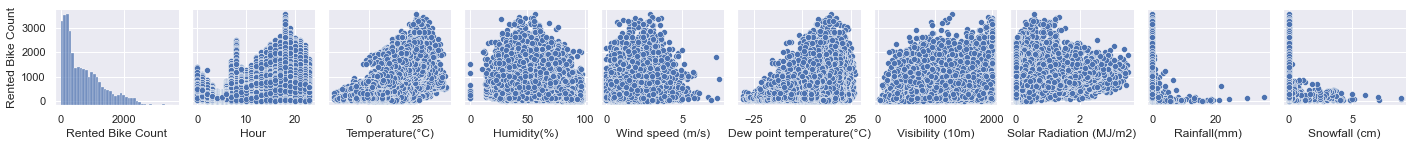

In [5]:
sns.pairplot(SeoulBikeDataTidy, height = 2,
            y_vars='Rented Bike Count')

Looking at the boxplot below that shows the distribution of the rented bike count for the seasons, Summmer is the peak season for renting bikes, while not many are rented in the winter. Similarly, in the second boxplot, we see that more bikes are rented during the holidays. Both graphs below show many outliers. The effect of the outliers appearing in the graphs can be reduced if a transformation is applied to the rented bike count. 

<AxesSubplot:xlabel='Seasons', ylabel='Rented Bike Count'>

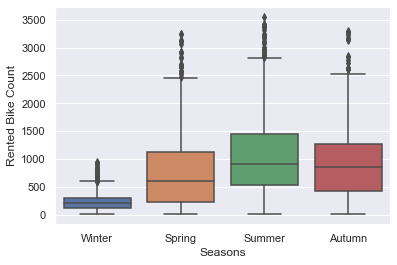

In [6]:
sns.boxplot(x="Seasons", y="Rented Bike Count",
                 data=SeoulBikeDataTidy)

<AxesSubplot:xlabel='Holiday', ylabel='Rented Bike Count'>

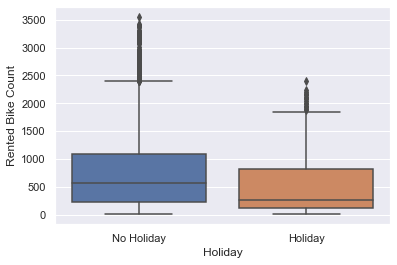

In [7]:
sns.boxplot(x="Holiday", y="Rented Bike Count",
                 data=SeoulBikeDataTidy)

The square root of the rented bike count has a less skewed distribution than the distribution for the rented bike count, as seen in the histogram below,. The square root transformation was choosen since the goal was simply to reduce the skewness, and not necessarily get a perfectly normally distributed response variable. Additionally, the square root is a simple transformation that is not hard to interpret. So, we can predict the square root of the rented bike count and reach a generalizable model later in the report, from which the rented bike count can still be deduced.

In [8]:
SeoulBikeDataTidy['TransfRBC'] = SeoulBikeDataTidy['Rented Bike Count'].pow(1/2)

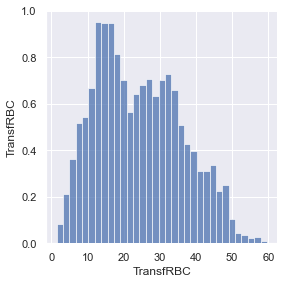

In [9]:
sns.pairplot(SeoulBikeDataTidy, height = 4,
            y_vars='TransfRBC',
            x_vars='TransfRBC')

Below, we see that the distribution of the square root rented bike count has little to no outliers for the different seasons and holidays.

<AxesSubplot:xlabel='Seasons', ylabel='TransfRBC'>

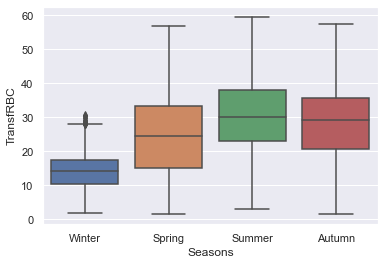

In [10]:
sns.boxplot(x="Seasons", y="TransfRBC",
                 data=SeoulBikeDataTidy)

<AxesSubplot:xlabel='Holiday', ylabel='TransfRBC'>

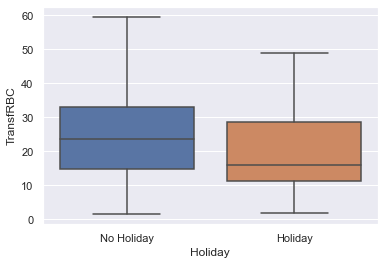

In [11]:
sns.boxplot(x="Holiday", y="TransfRBC",
                 data=SeoulBikeDataTidy)

The graph below shows the correlation between all the features and label that are considered in the study. Some relationships worth noting:

* Dew Point Temperature and Temperature are strongly correlated. 
* Humidity is strongly correlated with Visibility and Solar Radiation, but Visibility and Solar Radiation have a weak correlation.

These strong correlations may cause problems in the model fitting process.


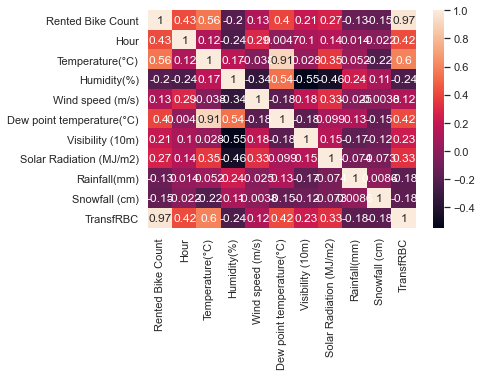

In [12]:
sns.heatmap(SeoulBikeDataTidy.corr(), annot=True)
plt.show()

## 2 - Prediction and Model Selection:

In order to reduce the effect of the outliers found earlier,the model will be selected such that it predicts the square root rented bike count.

### Phase 1: Initial Model Design:

The models that will be explored are polynomial regression models with degrees upto degree 5. Degree 5 is assumed to be a large enough degree since the initial model will have all 11 features. The categorical variables are turned into dummy/indicator variables to be used in the regression model. The distinct ranges with different widths of the continuous variables are handled by standardizing them (applied feature scaling). 

Two approaches are taken for training and testing the models: 10-fold cross-validation and a test-training split (40%-60% split).

In [13]:
features = ['Hour', 'Temperature(°C)', 
          'Humidity(%)', 'Wind speed (m/s)', 'Dew point temperature(°C)' ,  
          'Seasons', 'Holiday'  ,
          'Visibility (10m)', 'Solar Radiation (MJ/m2)' , 
          'Rainfall(mm)', 'Snowfall (cm)'
           ]
X = SeoulBikeDataTidy[features]
X = pd.get_dummies(data=X, drop_first=True)
Y = SeoulBikeDataTidy[['TransfRBC']]

In [14]:
d_range = list(range(1, 5))
d_cross_val = []
d_mse_test = []
d_mse_train = []
linreg = LinearRegression()

for d in d_range:
    poly = PolynomialFeatures(degree=d)
    scaler = StandardScaler()
    fitTransf = poly.fit_transform(X)
    fitTransf = scaler.fit_transform(fitTransf)
    
    d_cross_val.append(-1*cross_val_score(linreg, fitTransf, Y, cv=10, scoring='neg_mean_squared_error').mean())
    
    X_train, X_test, y_train, y_test = train_test_split(fitTransf, Y, test_size=0.4, random_state=4)
    linreg.fit(X_train, y_train)
    y_testpred = linreg.predict(X_test)
    y_trainpred = linreg.predict(X_train)
    
    d_mse_test.append(metrics.mean_squared_error(y_test, y_testpred))
    d_mse_train.append(metrics.mean_squared_error(y_train, y_trainpred))

From the graphs below, we see that the error from the 10-fold cross validation is low for small polynomial degrees, then increases rapidly (~ 2.5 x 1e23, from first graph), then decreases again. In contrast, the error from the test and train sets are significantly smaller (~ 35, from third graph) than the error from the cross-validation. This is the case especially for the lower polynomial degrees. This is unusual, since high bias is to be expected for lower polynomial degrees; instead there is high variance, which is a sign of overfitting and is problematic.

Text(0, 0.5, 'Mean Squared Error')

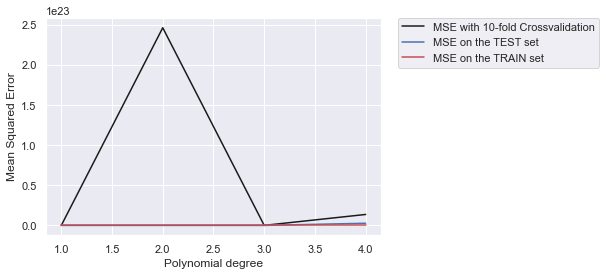

In [15]:
plt.plot(d_range, d_cross_val,'k', label='MSE with 10-fold Crossvalidation')
plt.plot(d_range, d_mse_test,'b', label='MSE on the TEST set')
plt.plot(d_range, d_mse_train,'r', label='MSE on the TRAIN set')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlabel('Polynomial degree')
plt.ylabel('Mean Squared Error')

Text(0, 0.5, 'Mean Squared Error')

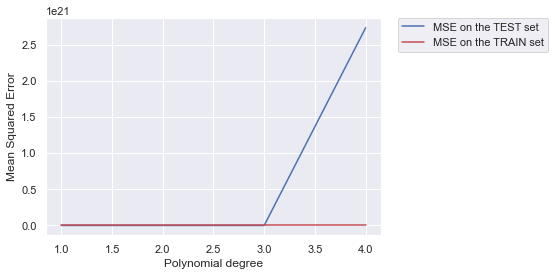

In [16]:
plt.plot(d_range, d_mse_test,'b', label='MSE on the TEST set')
plt.plot(d_range, d_mse_train,'r', label='MSE on the TRAIN set')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlabel('Polynomial degree')
plt.ylabel('Mean Squared Error')

Text(0, 0.5, 'Mean Squared Error')

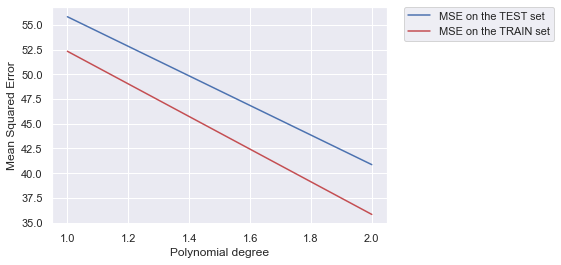

In [17]:
# previous plt but zoomed in
plt.plot(d_range[0:2], d_mse_test[0:2],'b', label='MSE on the TEST set')
plt.plot(d_range[0:2], d_mse_train[0:2],'r', label='MSE on the TRAIN set')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlabel('Polynomial degree')
plt.ylabel('Mean Squared Error')

### Phase 2: Feature Slection Part 1:

Due to the overfitting in the previous phase, some variables will be tested to check if their presence in the model is causing the overfitting. The features that will be removed from the model training are the categorical variables:
* Seasons: Winter, Spring, Summer, Autum
* Holiday: Holiday/No holiday

The models that will be explored are also polynomial regression models with degrees upto degree 5. Degree 5 is assumed to be a large enough degree since there are already many features in the model design. The distinct ranges with different widths of the continuous variables are handled by standardizing them (applied feature scaling). 

Two approaches are taken for training and testing the models: 10-fold cross-validation and a test-training split (40%-60% split).


In [18]:
features = ['Hour', 'Temperature(°C)', 
          'Humidity(%)', 'Wind speed (m/s)', 'Dew point temperature(°C)' ,  
          'Visibility (10m)', 'Solar Radiation (MJ/m2)' , 
          'Rainfall(mm)', 'Snowfall (cm)']
X = SeoulBikeDataTidy[features]
X = pd.get_dummies(data=X, drop_first=True)
Y = SeoulBikeDataTidy[['TransfRBC']]

In [19]:
d_range = list(range(1, 5))
d_cross_val = []
d_mse_test = []
d_mse_train = []
test_acc = []
train_acc = []
linreg = LinearRegression()

for d in d_range:
    poly = PolynomialFeatures(degree=d)
    scaler = StandardScaler()
    fitTransf = poly.fit_transform(X)
    fitTransf = scaler.fit_transform(fitTransf)
    
    d_cross_val.append(-1*cross_val_score(linreg, fitTransf, Y, cv=10, scoring='neg_mean_squared_error').mean())
    
    X_train, X_test, y_train, y_test = train_test_split(fitTransf, Y, test_size=0.4, random_state=4)
    linreg.fit(X_train, y_train)
    y_testpred = linreg.predict(X_test)
    y_trainpred = linreg.predict(X_train)
    
    d_mse_test.append(metrics.mean_squared_error(y_test, y_testpred))
    d_mse_train.append(metrics.mean_squared_error(y_train, y_trainpred))

Text(0, 0.5, 'Mean Squared Error')

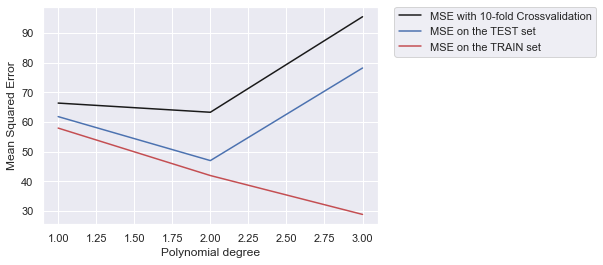

In [20]:
plt.plot(d_range[0:3], d_cross_val[0:3],'k', label='MSE with 10-fold Crossvalidation')
plt.plot(d_range[0:3], d_mse_test[0:3],'b', label='MSE on the TEST set')
plt.plot(d_range[0:3], d_mse_train[0:3],'r', label='MSE on the TRAIN set')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlabel('Polynomial degree')
plt.ylabel('Mean Squared Error')

As can be seen in the figure above, the spike in MSE with the 10-fold crossvalidation is no longer there for low polynomial degrees, which is an improvement from the first model design. Instead, we see a steady decrease in MSE before 2 degrees, and then a instant increase after 2 degrees. However, the elbow of the crossvalidation curve in the graph at 2 degrees is still excessivly larger than the MSE of the training set at 2 degrees. Perhaps the model can be simplified even more to reduce the MSE difference between the crossvalidation and the training set. 

Due to the positive effect that removing the Seasons and Holidays features had on the model, these two features will be removed in the next phase of feature selection.

The graphs below are of the learning curves for the model with the best polynomial degree for this simplified model design: degree 2. The second graph is a close up for the training error curve, which shows the error to almost plateau at a small value as the training set size increases (to ~ 17). Additionally, the first graph shows that the validation error gets very close to the training set error as the training set size increases past 1000 observations. The dataset used has 8465 observations, where the model validation done earlier was with 60% (5080 observations) for the training set. For approximately 5080 observatoins, the training error is small and close to the validation error, according to the figures below. So this model does not suffer from high variance (no overfitting) nor high bias (no underfitting). 

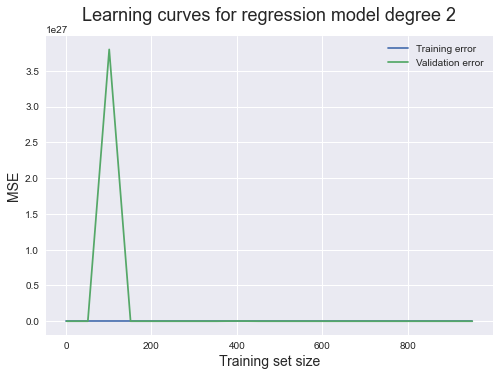

In [21]:
features = ['Hour', 'Temperature(°C)', 
          'Humidity(%)', 'Wind speed (m/s)', 'Dew point temperature(°C)' ,  
          'Visibility (10m)', 'Solar Radiation (MJ/m2)' , 
          'Rainfall(mm)', 'Snowfall (cm)']
X = SeoulBikeDataTidy[features]

linreg = LinearRegression()
poly = PolynomialFeatures(degree=2)
scaler = StandardScaler()
fitTransf = poly.fit_transform(X)
fitTransf = scaler.fit_transform(fitTransf)

train_sizes = range(1,1000, 50)
train_sizes, train_scores, val_scores = learning_curve(estimator = linreg, X = fitTransf,
                                                       y = Y, train_sizes = train_sizes, cv = 10,
                                                       scoring='neg_mean_squared_error')

train_scores_mean = -train_scores.mean(axis = 1)
val_scores_mean = -val_scores.mean(axis = 1)

plt.style.use('seaborn')
plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, val_scores_mean, label = 'Validation error')
plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for regression model degree 2', fontsize = 18, y = 1.03)
plt.legend()
#plt.ylim(0,2000000)

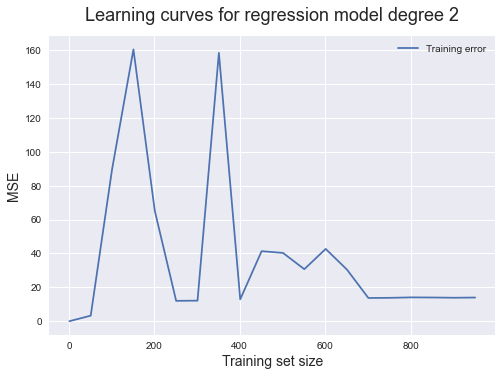

In [22]:
plt.style.use('seaborn')
plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for regression model degree 2', fontsize = 18, y = 1.03)
plt.legend()

### Phase 2: Feature Slection Part 2:

To simplify the model even more, the other variables that will be removed from the model training are:
* Dew point temperature(°C)
* Rainfall(mm)
* Snowfall (cm)
* Visibility (10m)
* Solar Radiation (MJ/m2)

Visibility (10m) and Solar Radiation (MJ/m2) are both removed since Humidity is strongly correlated with both of them, but Visibility and Solar Radiation have a low corrlation. Keeping 1/3 features that explains the other 2 features is more beneficial than keeping 2/3 feature. Dew point temperature(°C) is removed since it is strongly correlated with Temperature. Out of the two features, a citizen is assumed to be more likely aware of the temperature rather than the Dew point temperature, so the former feature more logically affects a citizen's decision to go and rent a bike. These high correlations may be causing multicollinearity, which is problematic.

Rainfall(mm) and Snowfall (cm) are removed since it was established that they have a heavily skewed distribution, while the other features do not. The heavily skewed nature of the data is problematic since more that 75% of the observations have a value of 0 rainfall and 0 snowfall, but a wide range of rented bike counts. This makes predicting the rented bike count difficult with the rainfall and snowfall. So, the benifit of Rainfall(mm) and Snowfall (cm) to the prediction model is questionable. 

The models that will be explored are also plynomial regression models with degrees upto degree 7. Degree 7 is used so that a wide range of models can be compared, since there are fewer original features in the model. The distinct ranges with different widths of the continuous variables are handled by standardizing them (applied feature scaling).  

Two approaches are taken for training and testing the models: 10-fold cross-validation and a test-training split (40%-60% split).

In [23]:
features = ['Hour', 'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)']
X = SeoulBikeDataTidy[features]
Y = SeoulBikeDataTidy[['TransfRBC']]

In [24]:
d_range = list(range(1, 7))
d_cross_val = []
d_mse_test = []
d_mse_train = []
test_acc = []
train_acc = []
linreg = LinearRegression()

for d in d_range:
    poly = PolynomialFeatures(degree=d)
    scaler = StandardScaler()
    fitTransf = poly.fit_transform(X)
    fitTransf = scaler.fit_transform(fitTransf)
    
    d_cross_val.append(-1*cross_val_score(linreg, fitTransf, Y, cv=10, scoring='neg_mean_squared_error').mean())
    
    X_train, X_test, y_train, y_test = train_test_split(fitTransf, Y, test_size=0.4, random_state=4)
    linreg.fit(X_train, y_train)
    y_testpred = linreg.predict(X_test)
    y_trainpred = linreg.predict(X_train)
    
    d_mse_test.append(metrics.mean_squared_error(y_test, y_testpred))
    d_mse_train.append(metrics.mean_squared_error(y_train, y_trainpred))
    
    test_acc.append(linreg.score(X_test, y_test))
    train_acc.append(linreg.score(X_train, y_train))

From the graph below, we see that removing the features that we did resulted in a lower MSE for each of the train, test, and crossvalidation sets. Additionally, the MSE in all three curves are closer to eachother at the elbow of the crossvalidation curve. The model design is best for a polynomial degree of 5, since that is where the elbow of the crossvalidation curve is located.

Text(0, 0.5, 'Mean Squared Error')

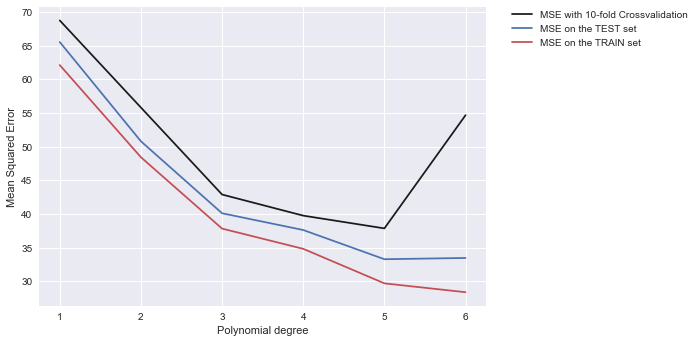

In [25]:
plt.plot(d_range, d_cross_val,'k', label='MSE with 10-fold Crossvalidation')
plt.plot(d_range, d_mse_test,'b', label='MSE on the TEST set')
plt.plot(d_range, d_mse_train,'r', label='MSE on the TRAIN set')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlabel('Polynomial degree')
plt.ylabel('Mean Squared Error')

Text(0, 0.5, 'R^2')

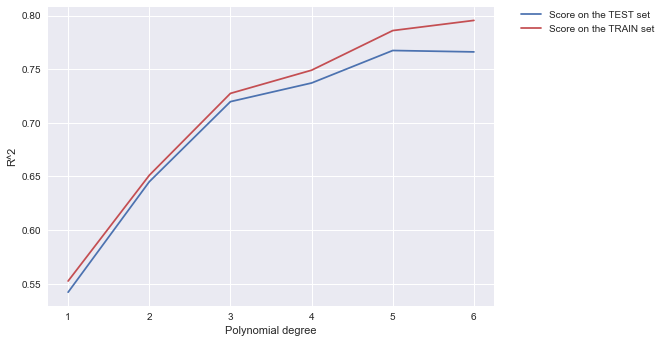

In [26]:
plt.plot(d_range, test_acc,'b', label='Score on the TEST set')
plt.plot(d_range, train_acc,'r', label='Score on the TRAIN set')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlabel('Polynomial degree')
plt.ylabel('R^2')

The graphs below are of the learning curves for the model with the best polynomial degree for this simplified model design: degree 5. The second graph is a close up for the training error curve, which shows the error to almost plateau at a small value as the training set size increases (to ~ 15). Additionally, the first graph shows that the validation error gets very close to the training set error as the training set size increases past 1000 observations. The dataset used has 8465 observations, where the model validation done earlier was with 60% (5080 observations) for the training set. For approximately 5080 observatoins, the training error is small and close to the validation error, according to the figures below. So this model does not suffer from high variance (no overfitting) nor high bias (no underfitting). 

(0.0, 20000000.0)

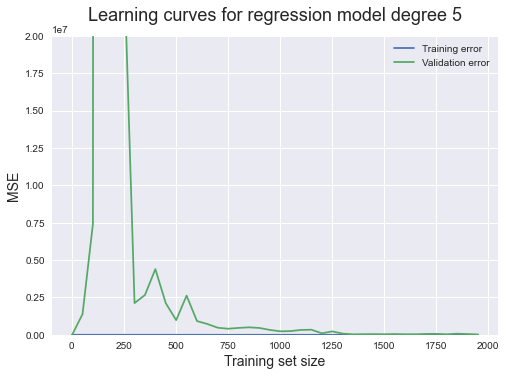

In [27]:
features = ['Hour', 'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)']
X = SeoulBikeDataTidy[features]

linreg = LinearRegression()
poly = PolynomialFeatures(degree=5)
scaler = StandardScaler()
fitTransf = poly.fit_transform(X)
fitTransf = scaler.fit_transform(fitTransf)

train_sizes = range(1,2000, 50)
train_sizes, train_scores, val_scores = learning_curve(estimator = linreg, X = fitTransf,
                                                       y = Y, train_sizes = train_sizes, cv = 10,
                                                       scoring='neg_mean_squared_error')

train_scores_mean = -train_scores.mean(axis = 1)
val_scores_mean = -val_scores.mean(axis = 1)

plt.style.use('seaborn')
plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, val_scores_mean, label = 'Validation error')
plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for regression model degree 5', fontsize = 18, y = 1.03)
plt.legend()
plt.ylim(0,20000000)

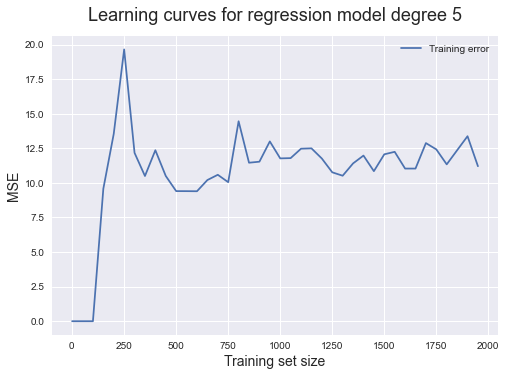

In [28]:
plt.style.use('seaborn')
plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for regression model degree 5', fontsize = 18, y = 1.03)
plt.legend()

### Phase 3: Model Design Comparison:

In phase 1, the model deign used all 11 original features. Polynomial Regression models of degree 1 to 5 with that model design were compared, which yielded an unusual MSE versus Polynomial degree 10-fold crossvalidation curve. The models with lower degree (less than degree 3) fit the training data very well, but not the crossvalidation data which has extremely large error for all 5 degrees (MSE reaches 1xe23). That shows that the models have high variance and are overfitting the training data.

In an attempt to simplify the model and reduce the overfitting, the categorical features 'Seasons' and 'Holidays' where determined to not be beneficial to the model, in phase 2 - part 1 of the feature selection process. The polynimial regression models of degree 1 to 5 without the two categorical features had lower MSE than the model desgin from phase 1. The MSE for the train, test, and crossvalidation sets are closer together for the different polynomial degrees. The best polynomial degree choice of the reduced model design is degree 2. Hence, this modle design simplication yielded a less complex model, with lower variance, and smaller MSE. 

Although a better model was obtained, an attempt to improve the model more was done in phase 2 - part 2 of the feature selection process, to try and reduce the MSE difference between the train, test, and crossvalidation sets. The features Dew point temperature(°C), Rainfall(mm), Snowfall (cm), Visibility (10m), and Solar Radiation (MJ/m2) were removed for the previously stated reasons, in addition to 'Seasons' and 'Holidays'. Removing these features improved the model design even more, since the MSE for the train, test, and crossvalidation sets got closer together for the different polynomial degrees, especially at the elbow of the crossvalidation curve (at degree 5). This reduced model design is better for prediciton with a polynimial degree of 5. That degree is higher than the degree of the previous model design with degree 2, making the model more complex and harder to interpret. However, the interpretability of the model is traded in for a reduced MSE for the train, test, and crossvalidation sets. Additionally, the previous R-squared graph shows that the model with only 'Hour', 'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)' as features with polynomial degree 5 explaines about 78.6 % of the variability of the square root rented bike count from the training set, and about 76.7% of the variability from the test set. Note that the percent variability of the test set explianed by the models start decreasing after 5 polynomial degrees, although the it is not very clear from the graphs; the cross-validation curve in the MSE vs Polynomial degree graph shows this better.

By comparing the learning curves for the last two models, we see that both have low variance at the sample size used for training the models, so both do not overfit the data. The second model (with degree 5 and 4 main features) has its validation and training error converge at a lower MSE than the first model (with degree 2 and 9 main features). So, the first model has higher bias than the second model, making the second model a more appropriate fit for the data. 


## Conclusion:

For this project, it was determined that the polynomial regression model with 'Hour', 'Temperature(°C)', 'Humidity(%)', and 'Wind speed (m/s)' as the original features taken to the 5th degree is the most appropraite model to predict the square root of the rented bike count, out of the different model designs and polynomial degrees explored. The model does not overfit nor underfit the training data. Note that the model also includes interactions. The model explaines about 78.6 % of the variability of the square root rented bike count from the training set, and about 76.7% of the variability from the test set. So, this model can predict the square root of the rented bike count reasonably well.

The choice to remove the 7 main features that we did vastly helped obtain a good fit model that has a high prediction accuracy score. The choice to use polynomial regression, rather than turning the problem into a classification problem, was also a good choice, since we resolved to predict the square-root of the rented bike count rather than predicting the rented bike count itself.

## Further Questions:

With the poynomial terms and interaction terms in the chosen model, the total number of features in the model is slightly large. Although the model has a high prediction accuracy score, other methods can be used to find a model that preforms better with a lower dimension. One such method is to test whether all the interactions currently in the model are necessary and helpful in predicting the rented bike count. Another method is to try and apply regularization to penalize the higher degree terms.

## Citations:

[1]  'Seoul Bike Sharing Demand Data Set', UCI, (2020-03). Accessed: 2021-01 https://archive.ics.uci.edu/ml/datasets/Seoul+Bike+Sharing+Demand)

[2] Bo-eun,Kim.'Seoul's bike-sharing system gaining popularity',The Korea Times.(2016-09-19). Accessed:2021-02. https://www.koreatimes.co.kr/www/nation/2021/01/113_214248.html)